In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from joblib import dump
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from joblib import load
import cv2
from wordcloud import WordCloud

import time
import seaborn as sns
from sklearn.metrics import make_scorer, precision_score, recall_score


import pickle

%matplotlib inline

In [ ]:
!pip -q install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/tugas akhir/data terbaru/balanced(500)_data_km.csv')

In [ ]:
data.head()

,tweet,label
0,@FRin_sane @apparentlyokay Wah iya bner nih ka...,negatif
1,"@alfariz101214 @apparentlyokay Setuju, kak. So...",negatif
2,Kenapa sih kalian mikir program Kampus merdeka...,positif
3,@andrifiadam Berkat kampus merdeka. Aku bisa m...,positif
4,Kampus merdeka itu solusi bagus buat jangka pe...,negatif


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [ ]:
print(f'total jumlah data : ', data.shape[0], 'data\n')

print('jumlah data positif : ', data[data.label=='positif'].shape[0], 'data')
print('jumlah data negatif : ', data[data.label=='negatif'].shape[0], 'data')

total jumlah data :  500 data

jumlah data positif :  250 data
jumlah data negatif :  250 data


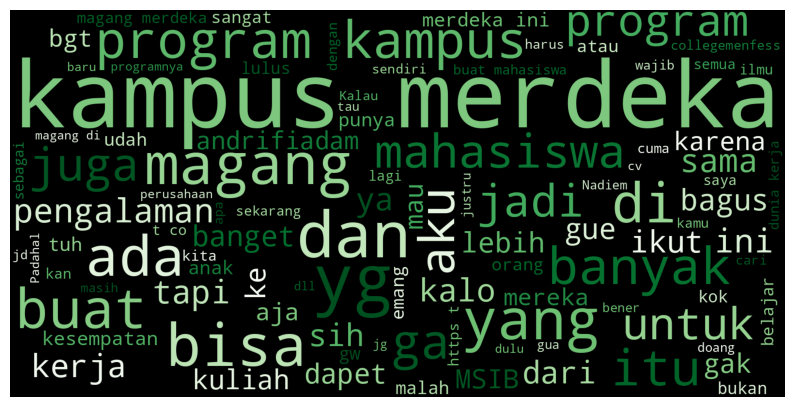

In [ ]:
positif_tweet = data[data['label']=='positif']
positif_string = []

for t in positif_tweet.tweet:
  positif_string.append(t)

positif_string = pd.Series(positif_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      colormap='Greens',
                      max_font_size=200, min_font_size=25,
                      contour_width=10, contour_color='firebrick',
                      max_words=100).generate(positif_string)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

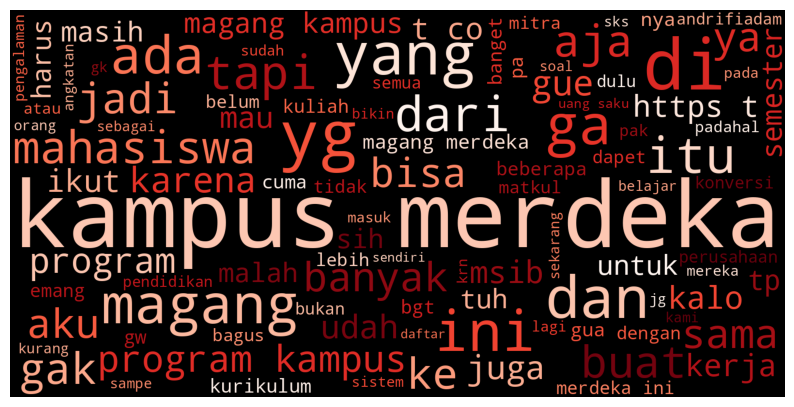

In [ ]:
negatif_tweet = data[data['label']=='negatif']
negatif_string = []

for t in negatif_tweet.tweet:
  negatif_string.append(t)

negatif_string = pd.Series(negatif_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      colormap='Reds',
                      max_font_size=200, min_font_size=25,
                      contour_width=10, contour_color='firebrick',
                      max_words=100).generate(negatif_string)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#PREPROCESSING

##CLEANING

In [ ]:
def casefolding(text):
  text = re.sub('@[^\s]+', ' ', text)
  text = text.lower()
  text = re.sub(r'https?://\S+|www\.\S+', '', text)
  text = re.sub(r'[-+]?[0-9]+', '', text)
  text = re.sub(r'[^\w\s]','', text)
  text = text.strip()
  return text

##NORMALISASI

In [ ]:
key_norm = pd.read_csv('/content/drive/MyDrive/tugas akhir/data terbaru/normalisasi_new.csv')
print(key_norm.head())

key_norm.shape

           singkat   hasil
0          bebener   benar
1       setujuuuuu  setuju
2             trus   terus
3  kerjaaaaaaaaaaa   kerja
4           okenya   pakai


(1206, 2)

In [ ]:
#fungsi normalisasi

def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

##STOPWORDS

In [ ]:
stopwords_ind = set(stopwords.words('indonesian'))

In [ ]:
len(stopwords_ind)

757

In [ ]:
stopwords_ind

{'ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [ ]:
with open('/content/drive/MyDrive/tugas akhir/data terbaru/stopwordlist.txt', 'r') as file:
    stopwords_custom = set(file.read().splitlines())

In [ ]:
stopwords_combined = stopwords_ind.union(stopwords_custom)

In [ ]:
stopwords_combined

{'kita',
 'keempat',
 'didapatkan',
 'ataukah',
 'ikutilah',
 'one',
 'sebelum',
 'sii',
 'bukannya',
 'belumlah',
 'iyakann',
 'kokk',
 'heuheuheu',
 'ye',
 'bapaknya',
 'menjawab',
 'siapakah',
 'terbanyak',
 'sedemikian',
 'tanyakan',
 'jelas',
 'hmmm',
 'cui',
 'benar',
 'semata',
 'semuanya',
 'dehhh',
 'tanya',
 'seseorang',
 'asalnya',
 'joran',
 'para',
 'ataupun',
 'depanku',
 'umumnya',
 'antaranya',
 'tetapi',
 'masih',
 'lama',
 'dirinya',
 'eta',
 'tuturnya',
 'pihaknya',
 'atau',
 'datanglah',
 'menandaskan',
 'sama-sama',
 'belakangan',
 'kepadanya',
 'mengatakan',
 'merupakan',
 'diakhiri',
 'mengenai',
 'katakanlah',
 'jadikan',
 'waktu',
 'diminta',
 'misalkan',
 'ibaratkan',
 'asalkan',
 'terasa',
 'disebutkannya',
 'bahwa',
 'disebutkan',
 'buat',
 'sedang',
 'bagaimanakah',
 'benarkah',
 'berikan',
 'disampaikannya',
 'kesampaian',
 'una',
 'hahahahahhaha',
 'mirip',
 'tadi',
 'bermacam',
 'lanjut',
 'sama',
 'sesuatu',
 'rrrrr',
 'tandas',
 'lohhh',
 'cukup',
 'an

In [ ]:
def remove_stopwords(text):
  clean_words = []
  text = text.split()
  for word in text:
    if word not in stopwords_combined:
      clean_words.append(word)
  return " ".join(clean_words)

##LEMMATIZATION

In [ ]:
def lemmatize_text(text):
  lemmatizer = WordNetLemmatizer()
  text = lemmatizer.lemmatize(text)
  return text

In [ ]:
import nltk
nltk.download('wordnet')
raw_sample = data['tweet'].iloc[0]
case_folding = casefolding(raw_sample)
normalize = text_normalize(case_folding)
stopword_removal = remove_stopwords(normalize)
lemmatizing = lemmatize_text(stopword_removal)

print('raw data\t: ', raw_sample)
print('case folding\t :', case_folding)
print('normalize\t: ', normalize)
print('stopwords removal\t: ', stopword_removal)
print('lemmatize\t: ', lemmatizing)

[nltk_data] Downloading package wordnet to /root/nltk_data...


raw data	:  @FRin_sane @apparentlyokay Wah iya bner nih kak, dlu pas awal2 kampus merdeka angkatanku agk kesusahan mau daftar krn di smt 5-6 msh ada matkul wajib yg hrs diambil (bs ikut tp gk ada convert sks), gktw stelahnya mgkin smcm ada rombak kurikulum biar angkatan bwh gk ribet ky sblmnya🙃
case folding	 : wah iya bner nih kak dlu pas awal kampus merdeka angkatanku agk kesusahan mau daftar krn di smt  msh ada matkul wajib yg hrs diambil bs ikut tp gk ada convert sks gktw stelahnya mgkin smcm ada rombak kurikulum biar angkatan bwh gk ribet ky sblmnya
normalize	:  wah iya benar nih kakak dulu pas awal kampus merdeka angkatanku agak kesusahan mau daftar karena di semester masih ada mata kuliah wajib yang harus diambil bisa ikut tapi tidak ada convert satuan kredit semester tidak tahu setelahnya mungkin semacam ada rombak kurikulum biar angkatan bawah tidak susah seperti sebelumnya
stopwords removal	:  iya kakak pas kampus merdeka angkatanku kesusahan daftar semester mata kuliah wajib 

##PREPROCESSING FUNCTION

In [ ]:
def preprocessing(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stopwords(text)
  text = lemmatize_text(text)

  return text

In [ ]:
%%time
data['clean_twt'] = data['tweet'].apply(preprocessing)



CPU times: user 7.13 s, sys: 165 ms, total: 7.29 s
Wall time: 10.9 s


In [ ]:
data.head()

,tweet,label,clean_twt
0,@FRin_sane @apparentlyokay Wah iya bner nih ka...,negatif,iya kakak pas kampus merdeka angkatanku kesusa...
1,"@alfariz101214 @apparentlyokay Setuju, kak. So...",negatif,setuju kakak jujur capek lihat tementemen seme...
2,Kenapa sih kalian mikir program Kampus merdeka...,positif,mikir program kampus merdeka kayak suka banget...
3,@andrifiadam Berkat kampus merdeka. Aku bisa m...,positif,berkat kampus merdeka magang perusahaan pupuk ...
4,Kampus merdeka itu solusi bagus buat jangka pe...,negatif,kampus merdeka solusi bagus jangka pendek solu...


In [ ]:
data.to_csv('clean_data.csv')

In [ ]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
data

,tweet,label,clean_twt
0,@FRin_sane @apparentlyokay Wah iya bner nih ka...,0,iya kakak pas kampus merdeka angkatanku kesusa...
1,"@alfariz101214 @apparentlyokay Setuju, kak. So...",0,setuju kakak jujur capek lihat tementemen seme...
2,Kenapa sih kalian mikir program Kampus merdeka...,1,mikir program kampus merdeka kayak suka banget...
3,@andrifiadam Berkat kampus merdeka. Aku bisa m...,1,berkat kampus merdeka magang perusahaan pupuk ...
4,Kampus merdeka itu solusi bagus buat jangka pe...,0,kampus merdeka solusi bagus jangka pendek solu...
...,...,...,...
495,@margianta Isu eksploitasi kerja seperti ini h...,0,isu eksploitasi kerja diperhatikan serius kamp...
496,Bagus banget nih adanya kampus merdeka. Mahasi...,1,bagus banget kampus merdeka mahasiswa galau ke...
497,Kalian nanti adek2 peserta magang kampus merde...,1,adek peserta magang kampus merdeka subsidi uan...
498,toh emang kampus merdeka sejak awal mahasiswan...,0,emang kampus merdeka mahasiswanya merdekakan t...


In [ ]:
X = data['clean_twt']
y = data['label']

##TF-IDF

In [ ]:
tf_idf=TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [ ]:
print(len(tf_idf.get_feature_names_out()))

2339


In [ ]:
print(tf_idf.get_feature_names_out())

['aamiin' 'aaminn' 'abis' ... 'zaman' 'zamannya' 'zonasi']


In [ ]:
X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aamiin,aaminn,abis,abroad,abstain,abu,acara,aceh,adala,adek,...,yatim,yauda,year,yes,you,your,youtube,zaman,zamannya,zonasi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.309735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

In [ ]:
X = np.array(data_tf_idf)
y = np.array(y)

#Seleksi Fitur dengan Chi-Square

In [ ]:
chi2_features = SelectKBest(chi2, k=1000)
X_kbest_features = chi2_features.fit_transform(X,y)

print('original feature nnumber : ', X.shape[1])
print('reduces feature number : ',  X_kbest_features.shape[1])

original feature nnumber :  2339
reduces feature number :  1000


In [ ]:
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])

In [ ]:
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.254606,aamiin
1,0.400952,aaminn
2,0.041472,abis
3,0.245004,abroad
4,0.272710,abstain
...,...,...
2334,0.215666,your
2335,0.335657,youtube
2336,0.017024,zaman
2337,0.254642,zamannya


In [ ]:
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
991,4.537843e+00,kesempatan
1274,4.090481e+00,membantu
1449,3.898917e+00,mitra
119,3.687439e+00,bagus
1287,3.412918e+00,memilih
...,...,...
1371,1.535735e-05,meninggalkan
1980,1.411790e-05,selamat
1248,7.314944e-06,mayoritas
1750,3.727347e-07,perusahaan


In [ ]:
mask = chi2_features.get_support()

In [ ]:
new_feature = []

for bool, f in zip(mask,feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aaminn',
 'abu',
 'acara',
 'adenya',
 'adil',
 'adilnya',
 'admin',
 'administrasi',
 'ahli',
 'ajang',
 'akademiknya',
 'akal',
 'akibat',
 'aksesibel',
 'aktivisme',
 'akui',
 'akun',
 'alami',
 'alasannya',
 'alesannya',
 'alhamdulillah',
 'alhamdulillahnya',
 'alhasil',
 'alih',
 'aliran',
 'alumni',
 'am',
 'ama',
 'aman',
 'ambil',
 'ampunan',
 'aneh',
 'aneh²',
 'angkatan',
 'anies',
 'anjay',
 'anjing',
 'antusias',
 'asa',
 'asbun',
 'aspirasi',
 'atasan',
 'awalawal',
 'awardee',
 'ayunan',
 'badan',
 'bagus',
 'bahagianya',
 'bahas',
 'bakat',
 'banget',
 'bangkit',
 'bangun',
 'bantu',
 'bantuan',
 'bany',
 'banyakan',
 'banyam',
 'barusan',
 'batal',
 'bawahnya',
 'bayangin',
 'bayar',
 'bayaran',
 'bayarannya',
 'beda²',
 'behhh',
 'bekal',
 'belajar',
 'belajarnya',
 'benahi',
 'benefitnya',
 'benerbener',
 'bentrok',
 'berani',
 'berantakan',
 'berbeda',
 'berbobot',
 'berdampak',
 'berekspresi',
 'berengsek',
 'beresiko',
 'berfaedah',
 'bergengsi',
 'berharap',
 'b

In [ ]:
kbest_feature = {}

for (k,v) in tf_idf.vocabulary_.items():
  if k in selected_feature:
    kbest_feature[k] = v

In [ ]:
kbest_feature

{'pas': 1632,
 'daftar': 359,
 'semester': 1987,
 'mata': 1240,
 'wajib': 2294,
 'satuan': 1936,
 'kredit': 1079,
 'kurikulum': 1102,
 'angkatan': 81,
 'susah': 2098,
 'program': 1824,
 'suka': 2085,
 'banget': 133,
 'mengajar': 1337,
 'konversi': 1068,
 'juta': 864,
 'potongan': 1798,
 'uang': 2250,
 'tunggal': 2237,
 'berkat': 213,
 'pupuk': 1846,
 'karyawannya': 897,
 'nadiem': 1473,
 'bagus': 119,
 'jangka': 829,
 'pembenahan': 1662,
 'perguruan': 1729,
 'mahasiswa': 1194,
 'cari': 317,
 'persaingan': 1740,
 'dunia': 583,
 'kerja': 977,
 'ngadi': 1504,
 'membantu': 1274,
 'sarjana': 1934,
 'pengen': 1702,
 'researcherpengusaha': 1888,
 'orang': 1598,
 'lupa': 1183,
 'only': 1590,
 'independent': 779,
 'pertukaran': 1748,
 'pelajar': 1645,
 'tergantung': 2150,
 'quotes': 1855,
 'menwhile': 1391,
 'masuk': 1237,
 'loh': 1158,
 'pilihan': 1760,
 'sisi': 2036,
 'independen': 778,
 'trust': 2223,
 'jalur': 823,
 'pengalaman': 1696,
 'gapunya': 668,
 'lingkungan': 1144,
 'koneksi': 1053,

In [ ]:
data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aaminn,abu,acara,adenya,adil,adilnya,admin,administrasi,ahli,ajang,...,wirausaha,wisuda,wkwkwk,wkwkwkw,woi,worth,woy,yah,yatim,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

#Modelling

##Tanpa Menggunakan Seleksi Fitur

###Support Vector Machine

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

In [ ]:
svm_model = SVC(C= 1, gamma= 0.1, kernel= 'linear')

start_time = time.time()

model = svm_model.fit(X_train, y_train)

training_time = time.time() - start_time
print("Training time:", training_time, "seconds")

dump(model, filename='model_1.joblib')

Training time: 0.2452554702758789 seconds


['model_1.joblib']

In [ ]:
model_pred = model.predict(X_test)

In [ ]:
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('jumlah prediksi benar\t :', prediksi_benar)
print('jumlah prediksi salah\t :', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('akurasi pengujian\t : ', accuracy, '%')

jumlah prediksi benar	 : 33
jumlah prediksi salah	 : 17
akurasi pengujian	 :  66.0 %


In [ ]:
cm = confusion_matrix(y_test, model_pred)
print('confusion_matrix :\n', cm)

confusion_matrix :
 [[19  7]
 [10 14]]


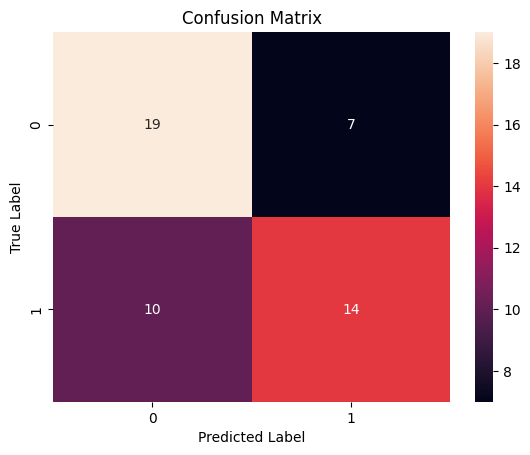

In [ ]:
# Confusion Matrix

import seaborn as sns

class_label = [0, 1]
df_cm = pd.DataFrame(confusion_matrix(y_test, model_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print('classification report:\n', classification_report(y_test, model_pred))

classification report:
               precision    recall  f1-score   support

           0       0.66      0.73      0.69        26
           1       0.67      0.58      0.62        24

    accuracy                           0.66        50
   macro avg       0.66      0.66      0.66        50
weighted avg       0.66      0.66      0.66        50



###Cross Validation

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=50)

scorer_precision = make_scorer(precision_score, average='macro')
scorer_recall = make_scorer(recall_score, average='macro')

cv_accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(model, X, y, cv=cv, scoring=scorer_precision)
cv_recall = cross_val_score(model, X, y, cv=cv, scoring=scorer_recall)

avg_accuracy = np.mean(cv_accuracy)
avg_precision = np.mean(cv_precision)
avg_recall = np.mean(cv_recall)

# Menampilkan nilai recall dan presisi untuk setiap lipatan
print("Akurasi setiap split:")
print([round(accuracy, 2) for accuracy in cv_accuracy])
print("\nRata-rata akurasi pada cross-validation:", round(avg_accuracy, 2))

print("\nPresisi setiap split:")
print([round(precision, 2) for precision in cv_precision])
print("\nRata-rata presisi pada cross-validation:", round(avg_precision, 2))

print("\nRecall setiap split:")
print([round(recall, 2) for recall in cv_recall])
print("\nRata-rata recall pada cross-validation:", round(avg_recall, 2))

Akurasi setiap split:
[0.74, 0.62, 0.82, 0.88, 0.74, 0.78, 0.72, 0.74, 0.72, 0.7]

Rata-rata akurasi pada cross-validation: 0.75

Presisi setiap split:
[0.74, 0.65, 0.81, 0.89, 0.75, 0.78, 0.71, 0.75, 0.72, 0.7]

Rata-rata presisi pada cross-validation: 0.75

Recall setiap split:
[0.73, 0.65, 0.82, 0.89, 0.75, 0.78, 0.7, 0.75, 0.72, 0.7]

Rata-rata recall pada cross-validation: 0.75


##Menggunakan Seleksi Fitur

###Support Vector Machine

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.1, random_state=40)

In [ ]:
svm_model = SVC(C= 1, gamma= 0.1, kernel= 'linear')


start_time = time.time()

model = svm_model.fit(X_train, y_train)

training_time = time.time() - start_time
print("Training time:", training_time, "seconds")

dump(model, filename='model_2.joblib')

Training time: 0.15347695350646973 seconds


['model_2.joblib']

In [ ]:
model_pred = model.predict(X_test)

In [ ]:
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('jumlah prediksi benar\t :', prediksi_benar)
print('jumlah prediksi salah\t :', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('akurasi pengujian\t : ', accuracy, '%')

jumlah prediksi benar	 : 40
jumlah prediksi salah	 : 10
akurasi pengujian	 :  80.0 %


In [ ]:
cm = confusion_matrix(y_test, model_pred)
print('confusion_matrix :\n', cm)

confusion_matrix :
 [[24  2]
 [ 8 16]]


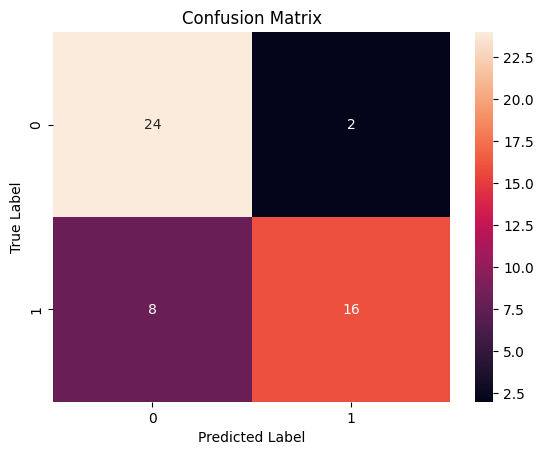

In [ ]:
class_label = [0, 1]
df_cm = pd.DataFrame(confusion_matrix(y_test, model_pred), index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print('classification report:\n', classification_report(y_test, model_pred))

classification report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83        26
           1       0.89      0.67      0.76        24

    accuracy                           0.80        50
   macro avg       0.82      0.79      0.79        50
weighted avg       0.82      0.80      0.80        50



###Cross Validation

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=50)

scorer_precision = make_scorer(precision_score, average='macro')
scorer_recall = make_scorer(recall_score, average='macro')

cv_accuracy = cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy')
cv_precision = cross_val_score(model, X_kbest_features, y, cv=cv, scoring=scorer_precision)
cv_recall = cross_val_score(model, X_kbest_features, y, cv=cv, scoring=scorer_recall)

avg_accuracy = np.mean(cv_accuracy)
avg_precision = np.mean(cv_precision)
avg_recall = np.mean(cv_recall)

# Menampilkan nilai recall dan presisi untuk setiap lipatan
print("Akurasi setiap split:")
print([round(accuracy, 2) for accuracy in cv_accuracy])
print("\nRata-rata akurasi pada cross-validation:", round(avg_accuracy, 2))

print("\nPresisi setiap split:")
print([round(precision, 2) for precision in cv_precision])
print("\nRata-rata presisi pada cross-validation:", round(avg_precision, 2))

print("\nRecall setiap split:")
print([round(recall, 2) for recall in cv_recall])
print("\nRata-rata recall pada cross-validation:", round(avg_recall, 2))

Akurasi setiap split:
[0.82, 0.82, 0.88, 0.92, 0.78, 0.84, 0.92, 0.84, 0.76, 0.86]

Rata-rata akurasi pada cross-validation: 0.84

Presisi setiap split:
[0.84, 0.82, 0.88, 0.92, 0.8, 0.85, 0.93, 0.85, 0.76, 0.86]

Rata-rata presisi pada cross-validation: 0.85

Recall setiap split:
[0.81, 0.85, 0.88, 0.92, 0.79, 0.84, 0.91, 0.85, 0.76, 0.86]

Rata-rata recall pada cross-validation: 0.85


#WORDCLOUD SETELAH MODELLING

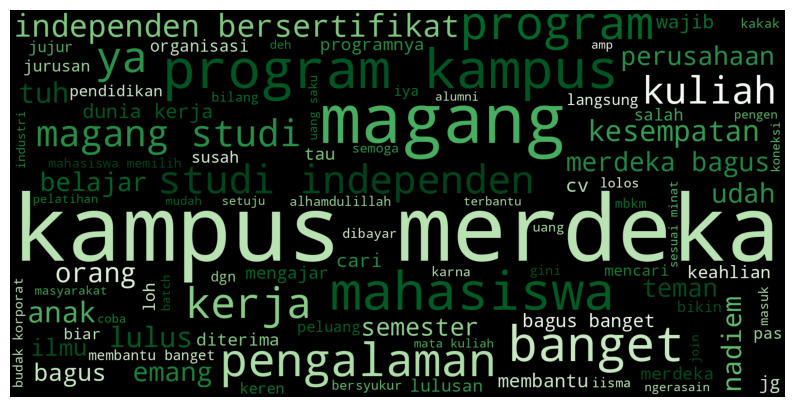

In [ ]:
positif_tweet = data[data['label']==1]
positif_string = []

for t in positif_tweet.clean_twt:
  positif_string.append(t)

positif_string = pd.Series(positif_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      colormap='Greens',
                      max_font_size=200, min_font_size=25,
                      contour_width=10, contour_color='firebrick',
                      max_words=100).generate(positif_string)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

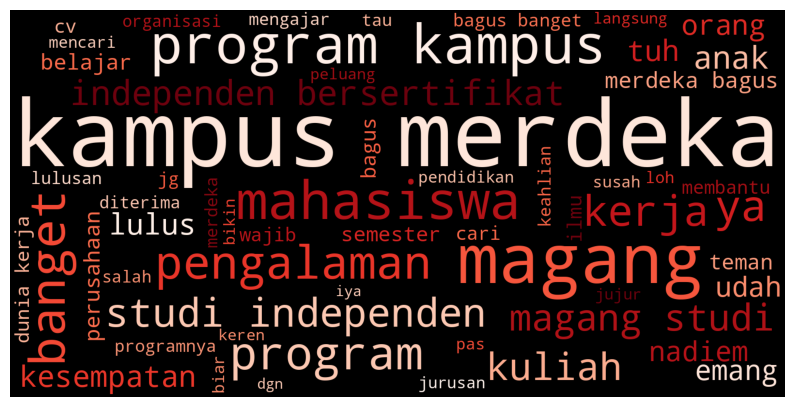

In [ ]:
negatif_tweet = data[data['label']==1]
negatif_string = []

for t in negatif_tweet.clean_twt:
  negatif_string.append(t)

negatif_string = pd.Series(negatif_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      colormap='Reds',
                      max_font_size=200, min_font_size=25,
                      contour_width=10, contour_color='firebrick',
                      max_words=100).generate(negatif_string)

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#PREDICTION

##Support Vector Machine

In [ ]:
from joblib import load
model=load('model_2.joblib')
vocab=pickle.load(open('kbest_feature.pickle', 'rb'))

###Positif

In [ ]:
input_text = "gak nyesel ikut kampus merdeka. ipk gue jadi bagus banget anjir"
pre_input_text=preprocessing(input_text)
tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))

# Mengubah input menjadi format dense
dense_input = tf_idf_vec.fit_transform([pre_input_text]).toarray()

# Melakukan prediksi dengan model SVC
result = model.predict(dense_input)

print("hasil text preprocessing : ", pre_input_text)

if(result==1):
  sentimen = "positif"
else:
  sentimen = "negatif"

print("hasil prediksi", input_text, 'adalah ->', sentimen)

hasil text preprocessing :  menyesal kampus merdeka ipk bagus banget anjir
hasil prediksi gak nyesel ikut kampus merdeka. ipk gue jadi bagus banget anjir adalah -> positif


###Negatif

In [ ]:
input_text = "ngulang tahun depan karna kampus ga ngebolehin kita buat konversi"
pre_input_text=preprocessing(input_text)
# Mengubah input menjadi format dense
dense_input = tf_idf_vec.fit_transform([pre_input_text]).toarray()

# Melakukan prediksi dengan model SVC
result = model.predict(dense_input)

print("hasil text preprocessing : ", pre_input_text)

if(result==1):
  sentimen = "positif"
else:
  sentimen = "negatif"

print("hasil prediksi", input_text, 'adalah ->', sentimen)

hasil text preprocessing :  ngulang karna kampus ngebolehin konversi
hasil prediksi ngulang tahun depan karna kampus ga ngebolehin kita buat konversi adalah -> negatif
